In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
#import tensorflow as tf
import holidays
import os
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense , LSTM
#from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

In [194]:
store_sales = pd.read_csv("/Users/hhamidizadeh/ReorderingSystem/INVENTORY-DEMAND-FORCASTING/4999122.csv")
store_sales

,Unnamed: 0,Planned dates,MRP element,MRP elmnt data,Rescheduling date,Exception,Rec./reqd qty,Avail. Quantity,Plng Plant,Stor. Loc.,Rec P. Qty,Day of the Week
0,NaN,11/26/2024,Stock,"On-Hold: 263,232.000 M",NaN,82.0,0.000,"394,848",NaN,NaN,NaN,Tuesday
1,NaN,11/26/2024,SafeSt,Safety Stock,NaN,NaN,"-1,579,392","-1,184,544",NaN,NaN,1579.39-,Tuesday
2,NaN,10/30/2024,PO,4500196146/00010,NaN,10.0,"789,696","-394,848",NaN,2000.0,789.70,Wednesday
3,NaN,11/27/2024,PO,4500202241/00010,11/26/2024,10.0,"394,848",0,NaN,2000.0,394.85,Wednesday
4,NaN,11/29/2024,Transf,0225098183/00010,NaN,NaN,"-43,872","-43,872",ORM2,2000.0,43.87-,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
467,NaN,12/4/2025,Transf,0225098447/00010,NaN,NaN,"-394,848","1,864,560",CRE1,2000.0,394.85-,Thursday
468,NaN,12/4/2025,Transf,0225099095/00010,NaN,NaN,"-98,712","1,765,848",ORM1,2000.0,98.71-,Thursday
469,NaN,12/4/2025,Transf,0225165809/00010,NaN,NaN,"-109,680","1,656,168",LAN1,2000.0,109.68-,Thursday
470,NaN,12/4/2025,Transf,0225165828/00010,NaN,NaN,"-252,264","1,403,904",LOC1,2000.0,252.26-,Thursday


In [195]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         0 non-null      float64
 1   Planned dates      472 non-null    object 
 2   MRP element        472 non-null    object 
 3   MRP elmnt data     472 non-null    object 
 4   Rescheduling date  4 non-null      object 
 5   Exception          6 non-null      float64
 6   Rec./reqd qty      472 non-null    object 
 7   Avail. Quantity    472 non-null    object 
 8   Plng Plant         417 non-null    object 
 9   Stor. Loc.         470 non-null    float64
 10  Rec P. Qty         471 non-null    object 
 11  Day of the Week    472 non-null    object 
dtypes: float64(3), object(9)
memory usage: 44.4+ KB


**Check for Missing Values:**

In [196]:
store_sales.isnull().sum()


Unnamed: 0           472
Planned dates          0
MRP element            0
MRP elmnt data         0
Rescheduling date    468
Exception            466
Rec./reqd qty          0
Avail. Quantity        0
Plng Plant            55
Stor. Loc.             2
Rec P. Qty             1
Day of the Week        0
dtype: int64

**Data Preprocessing**

In [197]:
store_sales = store_sales.drop(columns=['MRP element','MRP elmnt data','Rescheduling date','Exception','Plng Plant','Stor. Loc.','Rec P. Qty','Day of the Week'],axis=1) #Dropping store and items columns

In [198]:
store_sales['Planned dates'] = pd.to_datetime (store_sales['Planned dates']) #converting date from object datatype to date Time datatype
store_sales['Rec./reqd qty'] = store_sales['Rec./reqd qty'].str.replace(',', '').astype(float)
store_sales['Avail. Quantity'] = store_sales['Avail. Quantity'].str.replace(',', '').astype(float)

In [199]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       0 non-null      float64       
 1   Planned dates    472 non-null    datetime64[ns]
 2   Rec./reqd qty    472 non-null    float64       
 3   Avail. Quantity  472 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 14.9 KB


In [200]:
#store_sales['Planned dates'] = store_sales['Planned dates'].dt.to_period('M') #converting date to a Month period, and then sum the nmber of items in each month
#monthly_sales = store_sales.groupby('Planned dates').sum().reset_index()
store_sales['Planned dates'] = pd.to_datetime(store_sales['Planned dates'])  # Ensure 'Planned dates' is datetime

# Group by biweekly periods
biweekly_sales = store_sales.groupby(pd.Grouper(key='Planned dates', freq='2W')).sum().reset_index()

# Display the biweekly sales
print(biweekly_sales.head())
print(biweekly_sales['Planned dates'].dtype)


  Planned dates  Unnamed: 0  Rec./reqd qty  Avail. Quantity
0    2024-11-03         0.0       789696.0        -394848.0
1    2024-11-17         0.0            0.0              0.0
2    2024-12-01         0.0     -1272288.0       -1052928.0
3    2024-12-15         0.0      1261320.0       12964176.0
4    2024-12-29         0.0      -219360.0       10573152.0
datetime64[ns]


In [112]:
#monthly_sales['Planned dates'] = monthly_sales['Planned dates'].dt.to_timestamp() #convert the resulting date column to timestamp datatype
#biweekly_sales['Planned dates'] = biweekly_sales['Planned dates'].dt.to_timestamp() #convert the resulting date column to timestamp datatype


In [201]:
#monthly_sales.head (10)
biweekly_sales.head(10)
biweekly_sales

,Planned dates,Unnamed: 0,Rec./reqd qty,Avail. Quantity
0,2024-11-03,0.0,789696.0,-394848.0
1,2024-11-17,0.0,0.0,0.0
2,2024-12-01,0.0,-1272288.0,-1052928.0
3,2024-12-15,0.0,1261320.0,12964176.0
4,2024-12-29,0.0,-219360.0,10573152.0
5,2025-01-12,0.0,186456.0,17153952.0
6,2025-01-26,0.0,-43872.0,29339400.0
7,2025-02-09,0.0,-43872.0,27803880.0
8,2025-02-23,0.0,-43872.0,34176288.0
9,2025-03-09,0.0,-54840.0,28472928.0


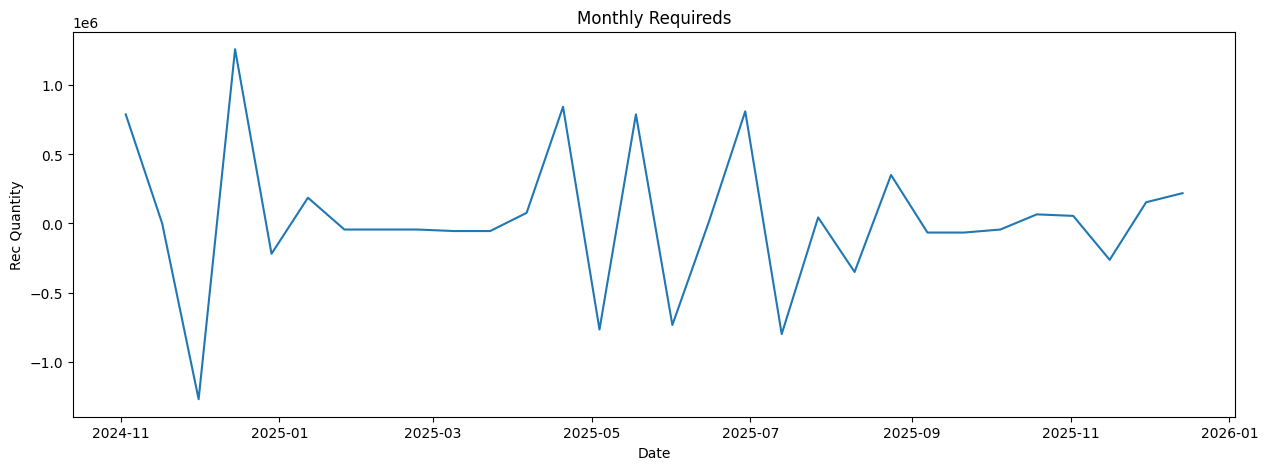

In [202]:
plt.figure(figsize=(15,5)) #Visualization
plt.plot(biweekly_sales['Planned dates'],biweekly_sales['Rec./reqd qty'])
plt.xlabel("Date")
plt.ylabel("Rec Quantity")
plt.title("Monthly Requireds")
plt.show()

In [203]:
biweekly_sales['req_diff'] = biweekly_sales['Rec./reqd qty'].diff() #call the difference on the sales columns to make the sales data stationery
biweekly_sales = biweekly_sales.dropna ()
biweekly_sales.head (10)
biweekly_sales

,Planned dates,Unnamed: 0,Rec./reqd qty,Avail. Quantity,req_diff
1,2024-11-17,0.0,0.0,0.0,-789696.0
2,2024-12-01,0.0,-1272288.0,-1052928.0,-1272288.0
3,2024-12-15,0.0,1261320.0,12964176.0,2533608.0
4,2024-12-29,0.0,-219360.0,10573152.0,-1480680.0
5,2025-01-12,0.0,186456.0,17153952.0,405816.0
6,2025-01-26,0.0,-43872.0,29339400.0,-230328.0
7,2025-02-09,0.0,-43872.0,27803880.0,0.0
8,2025-02-23,0.0,-43872.0,34176288.0,0.0
9,2025-03-09,0.0,-54840.0,28472928.0,-10968.0
10,2025-03-23,0.0,-54840.0,29131008.0,0.0


In [212]:
supervised_data = biweekly_sales.drop(['Planned dates', 'Rec./reqd qty'], axis=1) #Dropping off sales and date
supervised_data

,Unnamed: 0,Avail. Quantity,req_diff
1,0.0,0.0,-789696.0
2,0.0,-1052928.0,-1272288.0
3,0.0,12964176.0,2533608.0
4,0.0,10573152.0,-1480680.0
5,0.0,17153952.0,405816.0
6,0.0,29339400.0,-230328.0
7,0.0,27803880.0,0.0
8,0.0,34176288.0,0.0
9,0.0,28472928.0,-10968.0
10,0.0,29131008.0,0.0


In [213]:
for i in range(1,7): #preparing the supervised data
  col_name = 'biweek_' + str(i)
  supervised_data[col_name] = supervised_data['req_diff'].shift(i)
supervised_data = supervised_data.dropna()
supervised_data.head()

,Unnamed: 0,Avail. Quantity,req_diff,biweek_1,biweek_2,biweek_3,biweek_4,biweek_5,biweek_6
7,0.0,27803880.0,0.0,-230328.0,405816.0,-1480680.0,2533608.0,-1272288.0,-789696.0
8,0.0,34176288.0,0.0,0.0,-230328.0,405816.0,-1480680.0,2533608.0,-1272288.0
9,0.0,28472928.0,-10968.0,0.0,0.0,-230328.0,405816.0,-1480680.0,2533608.0
10,0.0,29131008.0,0.0,-10968.0,0.0,0.0,-230328.0,405816.0,-1480680.0
11,0.0,30227808.0,131616.0,0.0,-10968.0,0.0,0.0,-230328.0,405816.0


In [214]:
train_data = supervised_data[:-6]
test_data = supervised_data[-6:]
print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (17, 9)
Test Data Shape:  (6, 9)


In [215]:
scaler = MinMaxScaler (feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [223]:
X_train, y_train= train_data[:,1:], train_data[:,0:1]
X_test, y_test=test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test= y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (17, 8)
y_train Shape:  (17,)
X_test Shape:  (6, 8)
y_test Shape:  (6,)


In [224]:
sales_dates = biweekly_sales['Planned dates'][-6:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [225]:
act_sales = biweekly_sales['Rec./reqd qty'][-7:].to_list()
print(act_sales)

[-65808.0, -43872.0, 65808.0, 54840.0, -263232.0, 153552.0, 219360.0]


In [226]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre=lr_model.predict(X_test)

In [227]:
lr_pre =lr_pre.reshape(-1,1)
# This is a set matrix - contains the input features of the test data, and also the predicted output
lr_pre_test_set = np.concatenate ([lr_pre, X_test], axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)

In [228]:
result_list =[]
for index in range(0, len(lr_pre_test_set)):
   result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd. Series (result_list, name="Linear Prediction")
predict_df = predict_df.merge (lr_pre_series, left_index = True, right_index= True)
print(predict_df.columns)
print(biweekly_sales.columns)

Index(['Planned dates', 'Linear Prediction'], dtype='object')
Index(['Planned dates', 'Unnamed: 0', 'Rec./reqd qty', 'Avail. Quantity',
       'req_diff'],
      dtype='object')


In [230]:
# print(predict_df)
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], biweekly_sales['Rec./reqd qty'] [-6:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], biweekly_sales['Rec./reqd qty'][-6:])
lr_r2 = r2_score (predict_df['Linear Prediction'], biweekly_sales['Rec./reqd qty'] [-6:])
print("Linear Regression MSE: ", lr_mse )
print("Linear Regression MAE: ", lr_mae )
print("Linear Regression R2: ", lr_r2 )

Linear Regression MSE:  220544.99927225735
Linear Regression MAE:  157208.0
Linear Regression R2:  -1.7837062535857715


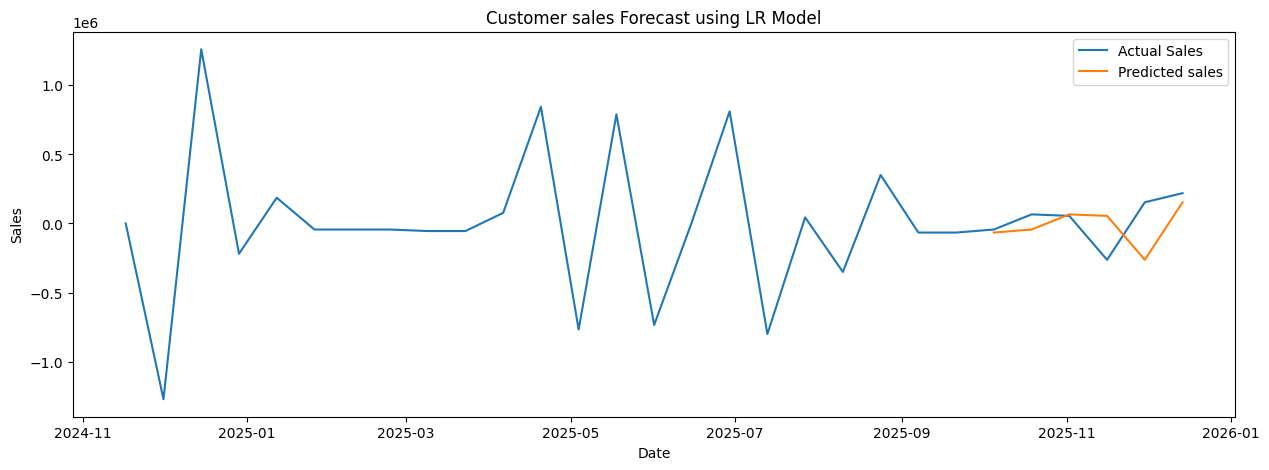

In [232]:
plt.figure(figsize=(15,5))
# Actual sales
plt.plot(biweekly_sales['Planned dates'], biweekly_sales['Rec./reqd qty'])
# Predicted sales
plt.plot(predict_df['Planned dates'], predict_df['Linear Prediction'])
plt.title("Customer sales Forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend (['Actual Sales', 'Predicted sales'])
plt.show()